In [1]:
# Run this in a separate cell first
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-obm9dhaj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-obm9dhaj
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import clip
import numpy as np
from tqdm import tqdm
import matplotlib. pyplot as plt


import seaborn as sns
from sklearn.manifold import TSNE
import umap
from tqdm import tqdm
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

from scipy.linalg import orthogonal_procrustes

2025-10-15 19:16:25.019247: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760555785.232008      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760555785.286867      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
mean = (0.48145466, 0.4578275, 0.40821073)
std  = (0.26862954, 0.26130258, 0.27577711)
office_home_classes = [
    "Alarm_Clock", "Backpack", "Batteries", "Bed", "Bike", "Bottle",
    "Bucket", "Calculator", "Calendar", "Candles", "Chair", "Clipboards",
    "Computer", "Couch", "Curtains", "Desk_Lamp", "Drill", "Eraser",
    "Exit_Sign", "Fan", "File_Cabinet", "Flipflops", "Flowers", "Folder",
    "Fork", "Glasses", "Hammer", "Helmet", "Kettle", "Keyboard", "Knives",
    "Lamp_Shade", "Laptop", "Marker", "Monitor", "Mop", "Mouse", "Mug",
    "Notebook", "Oven", "Pan", "Paper_Clip", "Pen", "Pencil", "Postit_Notes",
    "Printer", "Push_Pin", "Radio", "Refrigerator", "Ruler", "Scissors",
    "Screwdriver", "Shelf", "Sink", "Sneakers", "Soda", "Speaker",
    "Spoon", "Table", "Telephone", "ToothBrush", "Toys", "Trash_Can",
    "TV", "Webcam"
]


In [4]:
from torch.utils.data import ConcatDataset, DataLoader
from torchvision import datasets

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

# Path to your dataset
root_dir = "/kaggle/input/office-home/OfficeHomeDataset_10072016"

test_domain = ["Art", "Clipart", "Product", "Real World"]

domains = ["Art", "Clipart", "Product", "Real World"]

def load_domain(name):
    return datasets.ImageFolder(f"{root_dir}/{name}", transform=transform)

datasets_dict = {d: load_domain(d) for d in domains}

test_loader_dict = {}
for each_domain, each_dataset in datasets_dict.items():
   test_loader_dict[each_domain] = DataLoader(each_dataset, batch_size=64, shuffle=True,num_workers = 2, pin_memory=True)


# Check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load CLIP model
model, preprocess = clip.load("ViT-B/16", device=device)

Using device: cuda


100%|███████████████████████████████████████| 335M/335M [00:10<00:00, 33.9MiB/s]


In [5]:
# def create_text_prompts(class_names, prompt_style="plain"):
#     """Create text prompts for different styles"""
    
#     if prompt_style == "Art":
   
#         prompts = [f"a photo of a {cls}" for cls in class_names]
#     elif prompt_style == "Clipart":
   
#         prompts = [f"a photo of a {cls}" for cls in class_names]
#     elif prompt_style == "Product":
   
#         prompts = [f"a photo image of a {cls}" for cls in class_names]
#     elif prompt_style == "Real World":
   
#         prompts = [f"a photo of a {cls}" for cls in class_names]
   
#     else:
#         raise ValueError(f"Unknown prompt style: {prompt_style}")
    
#     return prompts


def create_text_prompts(class_names, prompt_style="plain"):
    """Create text prompts for different styles"""
    
    if prompt_style == "Art":
   
        prompts = [f"a painting of a {cls}" for cls in class_names]
    elif prompt_style == "Clipart":
   
        prompts = [f"a cartoon of a {cls}" for cls in class_names]
    elif prompt_style == "Product":
   
        prompts = [f"a photo image of a {cls}" for cls in class_names]
    elif prompt_style == "Real World":
   
        prompts = [f"a photo of a {cls}" for cls in class_names]
   
    else:
        raise ValueError(f"Unknown prompt style: {prompt_style}")
    
    return prompts



# Task 3.1 a Zero-Shot

In [6]:
def evaluate_zero_shot(model, test_loader, class_names, prompt_style="plain", device="cuda"):
    """Evaluate zero-shot classification accuracy"""
    
    # Create text prompts
    text_prompts = create_text_prompts(class_names, prompt_style)
    print(f"\nPrompt style: {prompt_style}")
    print("Sample prompts:")
    for i, prompt in enumerate(text_prompts[:3]):
        print(f"  {class_names[i]}: '{prompt}'")
    
    # Encode text prompts
    text_tokens = clip.tokenize(text_prompts).to(device)
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        # Get text features once
        text_features = model.encode_text(text_tokens)
        text_features = F.normalize(text_features, dim=-1)
        
        for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc=f"Evaluating {prompt_style}")):
            images = images.to(device)
            labels = labels.to(device)
            
            # Get image features
            image_features = model.encode_image(images)
            image_features = F.normalize(image_features, dim=-1)
            
            # Calculate similarities
            similarities = torch.matmul(image_features, text_features.T)
            
            # Get predictions
            predictions = similarities.argmax(dim=-1)
            
            # Calculate accuracy
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    print(f"Accuracy with {prompt_style} prompts: {accuracy:.4f} ({correct}/{total})")
    return accuracy



FULL TEST SET EVALUATION

Prompt style: Art
Sample prompts:
  Alarm_Clock: 'a photo of a Alarm_Clock'
  Backpack: 'a photo of a Backpack'
  Batteries: 'a photo of a Batteries'


Evaluating Art: 100%|██████████| 38/38 [00:17<00:00,  2.15it/s]


Accuracy with Art prompts: 0.7454 (1809/2427)

Prompt style: Clipart
Sample prompts:
  Alarm_Clock: 'a photo of a Alarm_Clock'
  Backpack: 'a photo of a Backpack'
  Batteries: 'a photo of a Batteries'


Evaluating Clipart: 100%|██████████| 69/69 [00:26<00:00,  2.65it/s]


Accuracy with Clipart prompts: 0.6149 (2684/4365)

Prompt style: Product
Sample prompts:
  Alarm_Clock: 'a photo image of a Alarm_Clock'
  Backpack: 'a photo image of a Backpack'
  Batteries: 'a photo image of a Batteries'


Evaluating Product: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Accuracy with Product prompts: 0.8191 (3636/4439)

Prompt style: Real World
Sample prompts:
  Alarm_Clock: 'a photo of a Alarm_Clock'
  Backpack: 'a photo of a Backpack'
  Batteries: 'a photo of a Batteries'


Evaluating Real World: 100%|██████████| 69/69 [01:00<00:00,  1.14it/s]


Accuracy with Real World prompts: 0.8022 (3495/4357)

FINAL RESULTS
Art prompts: 0.7454 (74.54%)
Clipart prompts: 0.6149 (61.49%)
Product prompts: 0.8191 (81.91%)
Real world prompts: 0.8022 (80.22%)


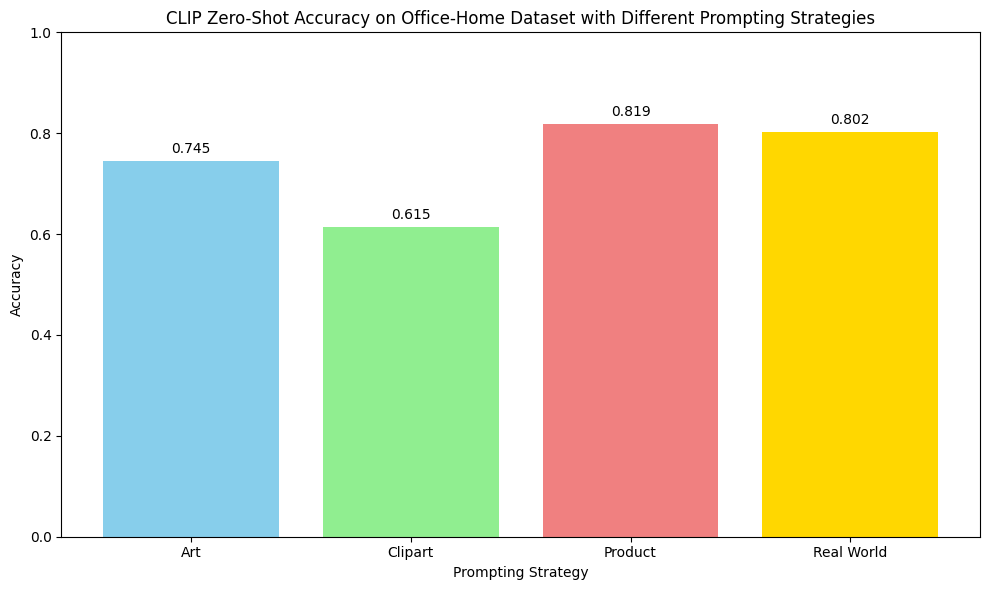

In [7]:

# Evaluate on full test set with different prompting strategies
print("\n" + "="*50)
print("FULL TEST SET EVALUATION")
print("="*50)

results = {}

for each_domain in domains:
    test_loader = test_loader_dict[each_domain]
    accuracy = evaluate_zero_shot(model, test_loader, office_home_classes, each_domain, device)
    results[each_domain] = accuracy
    
    

# Display results
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
for eachdomain, accuracy in results.items():
    print(f"{eachdomain.capitalize()} prompts: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Plot results
plt.figure(figsize=(10, 6))
alldomains = list(results.keys())
accuracies = list(results.values())

plt.bar(alldomains, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.xlabel('Prompting Strategy')
plt.ylabel('Accuracy')
plt.title('CLIP Zero-Shot Accuracy on Office-Home Dataset with Different Prompting Strategies')
plt.ylim(0, 1)

# Add value labels on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


FULL TEST SET EVALUATION

Prompt style: Art
Sample prompts:
  Alarm_Clock: 'a painting of a Alarm_Clock'
  Backpack: 'a painting of a Backpack'
  Batteries: 'a painting of a Batteries'


Evaluating Art: 100%|██████████| 38/38 [00:15<00:00,  2.53it/s]


Accuracy with Art prompts: 0.7454 (1809/2427)

Prompt style: Clipart
Sample prompts:
  Alarm_Clock: 'a cartoon of a Alarm_Clock'
  Backpack: 'a cartoon of a Backpack'
  Batteries: 'a cartoon of a Batteries'


Evaluating Clipart: 100%|██████████| 69/69 [00:25<00:00,  2.67it/s]


Accuracy with Clipart prompts: 0.6151 (2685/4365)

Prompt style: Product
Sample prompts:
  Alarm_Clock: 'a product image of a Alarm_Clock'
  Backpack: 'a product image of a Backpack'
  Batteries: 'a product image of a Batteries'


Evaluating Product: 100%|██████████| 70/70 [00:26<00:00,  2.65it/s]


Accuracy with Product prompts: 0.8371 (3716/4439)

Prompt style: Real World
Sample prompts:
  Alarm_Clock: 'a photo of a Alarm_Clock'
  Backpack: 'a photo of a Backpack'
  Batteries: 'a photo of a Batteries'


Evaluating Real World: 100%|██████████| 69/69 [00:53<00:00,  1.28it/s]


Accuracy with Real World prompts: 0.8022 (3495/4357)

FINAL RESULTS
Art prompts: 0.7454 (74.54%)
Clipart prompts: 0.6151 (61.51%)
Product prompts: 0.8371 (83.71%)
Real world prompts: 0.8022 (80.22%)


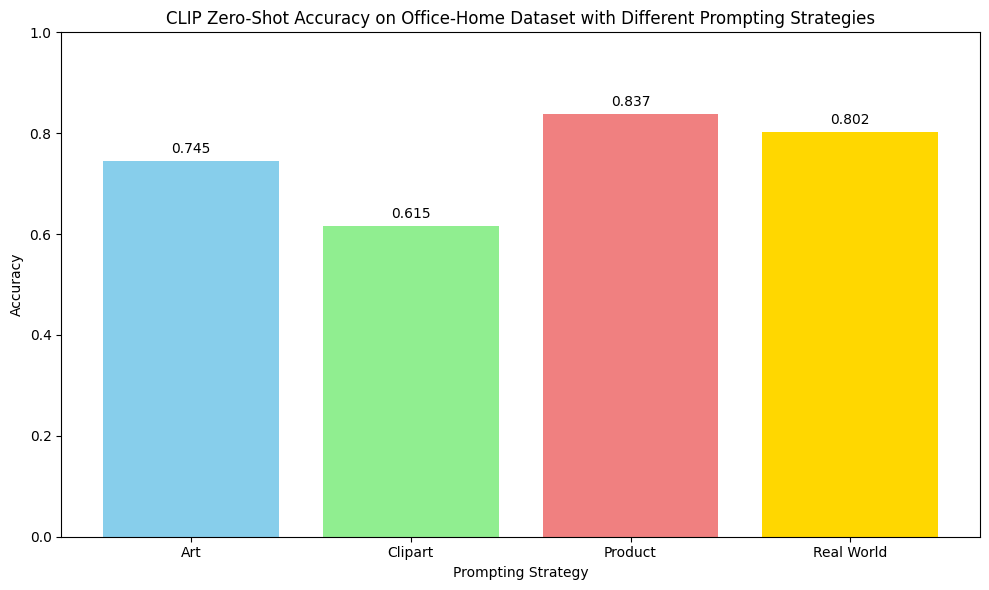

In [9]:

# Evaluate on full test set with different prompting strategies
print("\n" + "="*50)
print("FULL TEST SET EVALUATION")
print("="*50)

prompt_strategies = ["simple"]
results = {}

for each_domain in domains:
    test_loader = test_loader_dict[each_domain]
    accuracy = evaluate_zero_shot(model, test_loader, office_home_classes, each_domain, device)
    results[each_domain] = accuracy
    
    

# Display results
print("\n" + "="*50)
print("FINAL RESULTS")
print("="*50)
for eachdomain, accuracy in results.items():
    print(f"{eachdomain.capitalize()} prompts: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Plot results
plt.figure(figsize=(10, 6))
alldomains = list(results.keys())
accuracies = list(results.values())

plt.bar(alldomains, accuracies, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.xlabel('Prompting Strategy')
plt.ylabel('Accuracy')
plt.title('CLIP Zero-Shot Accuracy on Office-Home Dataset with Different Prompting Strategies')
plt.ylim(0, 1)

# Add value labels on bars
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluating the out of the box capability of Clip model on Office home dataset

# Zero shot classification on all the domains

# the prompts were not adjusted :

# the prompts were adjusted :


# Task 3.1 b Fine-tuned on Domains

In [7]:
class CLIPClassifier(nn.Module):
    def __init__(self, clip_model, num_classes, freeze_clip=True):
        super().__init__()
        self.clip_model = clip_model
        if freeze_clip:
            for param in self.clip_model.parameters():
                param.requires_grad = False
        self.classifier = nn.Linear(clip_model.visual.output_dim, num_classes)
    
    def forward(self, images):
        with torch.no_grad():
            image_features = self.clip_model.encode_image(images).float()
        image_features = F.normalize(image_features, dim=-1)
        logits = self.classifier(image_features)
        return logits


In [8]:
def evaluate_source_only(model, data_loader, device="cuda"):
    model.eval()
    total_correct, total_samples = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_samples += labels.size(0)
    acc = total_correct / total_samples
    print(f"Accuracy: {acc:.4f}")
    return acc


In [9]:
def train_source_only(model, train_loader, val_loader, num_epochs=5, lr=1e-4, device="cuda"):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    
    model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            
            preds = logits.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)
        
        train_acc = total_correct / total_samples
        train_loss = total_loss / total_samples
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        
        # optional validation on target to see progress
        if val_loader is not None:
            evaluate_source_only(model, val_loader, device)


In [13]:
from torch.utils.data import ConcatDataset, DataLoader

# Define source and target
source_domains = ["Clipart", "Product", "Real World"]
target_domain = "Art"

# Concatenate source datasets
source_datasets = [datasets_dict[domain] for domain in source_domains]
combined_source = ConcatDataset(source_datasets)

print(f"Total source samples: {len(combined_source)}")

# Create train loader
train_loader = DataLoader(
    combined_source,
    batch_size=128,
    shuffle=True,  # Important: shuffle for training!
    num_workers=2
)

# Target loader (already created)
target_test_loader = test_loader_dict[target_domain]

# Also keep individual source test loaders for evaluation
source_test_loaders = {domain: test_loader_dict[domain] for domain in source_domains}

Total source samples: 13161


In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/16", device=device)

num_classes = 65  # OfficeHome has 65 classes
source_model = CLIPClassifier(clip_model, num_classes, freeze_clip=True)

train_source_only(source_model, train_loader, target_test_loader, num_epochs=20, lr=1e-3, device=device)


Epoch 1/20: 100%|██████████| 103/103 [01:28<00:00,  1.17it/s]


Train Loss: 3.9824 | Train Acc: 0.4716


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.40it/s]


Accuracy: 0.5707


Epoch 2/20: 100%|██████████| 103/103 [01:29<00:00,  1.15it/s]


Train Loss: 3.6091 | Train Acc: 0.6877


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.41it/s]


Accuracy: 0.6461


Epoch 3/20: 100%|██████████| 103/103 [01:29<00:00,  1.16it/s]


Train Loss: 3.2606 | Train Acc: 0.7400


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.46it/s]


Accuracy: 0.6811


Epoch 4/20: 100%|██████████| 103/103 [01:30<00:00,  1.14it/s]


Train Loss: 2.9352 | Train Acc: 0.7877


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.40it/s]


Accuracy: 0.7108


Epoch 5/20: 100%|██████████| 103/103 [01:28<00:00,  1.17it/s]


Train Loss: 2.6354 | Train Acc: 0.8094


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.42it/s]


Accuracy: 0.7326


Epoch 6/20: 100%|██████████| 103/103 [01:29<00:00,  1.16it/s]


Train Loss: 2.3638 | Train Acc: 0.8294


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.40it/s]


Accuracy: 0.7470


Epoch 7/20: 100%|██████████| 103/103 [01:27<00:00,  1.18it/s]


Train Loss: 2.1217 | Train Acc: 0.8395


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.47it/s]


Accuracy: 0.7577


Epoch 8/20: 100%|██████████| 103/103 [01:29<00:00,  1.16it/s]


Train Loss: 1.9094 | Train Acc: 0.8481


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.46it/s]


Accuracy: 0.7643


Epoch 9/20: 100%|██████████| 103/103 [01:27<00:00,  1.18it/s]


Train Loss: 1.7253 | Train Acc: 0.8568


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.47it/s]


Accuracy: 0.7742


Epoch 10/20: 100%|██████████| 103/103 [01:29<00:00,  1.15it/s]


Train Loss: 1.5669 | Train Acc: 0.8612


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.52it/s]


Accuracy: 0.7796


Epoch 11/20: 100%|██████████| 103/103 [01:29<00:00,  1.15it/s]


Train Loss: 1.4310 | Train Acc: 0.8673


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.43it/s]


Accuracy: 0.7829


Epoch 12/20: 100%|██████████| 103/103 [01:28<00:00,  1.16it/s]


Train Loss: 1.3147 | Train Acc: 0.8717


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.43it/s]


Accuracy: 0.7866


Epoch 13/20: 100%|██████████| 103/103 [01:29<00:00,  1.15it/s]


Train Loss: 1.2150 | Train Acc: 0.8761


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.45it/s]


Accuracy: 0.7915


Epoch 14/20: 100%|██████████| 103/103 [01:30<00:00,  1.14it/s]


Train Loss: 1.1290 | Train Acc: 0.8790


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.46it/s]


Accuracy: 0.7948


Epoch 15/20: 100%|██████████| 103/103 [01:27<00:00,  1.18it/s]


Train Loss: 1.0545 | Train Acc: 0.8811


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.50it/s]


Accuracy: 0.7940


Epoch 16/20: 100%|██████████| 103/103 [01:28<00:00,  1.17it/s]


Train Loss: 0.9897 | Train Acc: 0.8835


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.42it/s]


Accuracy: 0.7952


Epoch 17/20: 100%|██████████| 103/103 [01:28<00:00,  1.17it/s]


Train Loss: 0.9330 | Train Acc: 0.8867


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.48it/s]


Accuracy: 0.7952


Epoch 18/20: 100%|██████████| 103/103 [01:30<00:00,  1.14it/s]


Train Loss: 0.8831 | Train Acc: 0.8882


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.43it/s]


Accuracy: 0.7977


Epoch 19/20: 100%|██████████| 103/103 [01:29<00:00,  1.15it/s]


Train Loss: 0.8389 | Train Acc: 0.8904


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.43it/s]


Accuracy: 0.7981


Epoch 20/20: 100%|██████████| 103/103 [01:27<00:00,  1.17it/s]


Train Loss: 0.7995 | Train Acc: 0.8911


Evaluating: 100%|██████████| 38/38 [00:15<00:00,  2.40it/s]

Accuracy: 0.7977


# Task 3.2 a -- Prompt Learning with CLIP 

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
from clip.simple_tokenizer import SimpleTokenizer



'''
Taken from CoOp Paper GitHub Repo
'''
# ----------------------------
# Text Encoder -- Taken from the paper
# ----------------------------
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # take features from the end-of-text (EOT) token
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection
        return x

# ----------------------------
# Prompt Learner Taken from the Paper
# ----------------------------
class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, n_ctx=16, device="cuda"):
        super().__init__()
        self.device = device
        self.n_cls = len(classnames)
        self.n_ctx = n_ctx

        # Initialize context vectors
        ctx_dim = clip_model.ln_final.weight.shape[0]
        ctx_vectors = torch.empty(n_ctx, ctx_dim, device=device)
        nn.init.normal_(ctx_vectors, std=0.02)
        self.ctx = nn.Parameter(ctx_vectors)  # unified context

        # Build full prompt strings for tokenization
        classnames_clean = [c.replace("_", " ") for c in classnames]
        prompt_strings = [" ".join(["X"] * n_ctx) + " " + c for c in classnames_clean]
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompt_strings]).to(device)

        # Embed prefix (SOS) and suffix (class names + EOS)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(clip_model.dtype)
        self.token_prefix = embedding[:, :1, :]       # SOS
        self.token_suffix = embedding[:, 1 + n_ctx:, :]  # class tokens + EOS

        self.tokenized_prompts = tokenized_prompts
        self.name_lens = [len(SimpleTokenizer().encode(c)) for c in classnames_clean]
        self.class_token_position = "end"

    def forward(self):
        # Expand unified context to all classes
        ctx_exp = self.ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        prompts = torch.cat([self.token_prefix, ctx_exp, self.token_suffix], dim=1)
        return prompts

# ----------------------------
# CLIP with CoOp Prompt
# ----------------------------
class CLIPWithPrompt(nn.Module):
    def __init__(self, clip_model, classnames, n_ctx=16, device="cuda"):
        super().__init__()
        self.device = device
        self.clip_model = clip_model
        self.clip_model.eval()  # freeze CLIP
        for p in self.clip_model.parameters():
            p.requires_grad = False

        self.prompt_learner = PromptLearner(clip_model, classnames, n_ctx, device=device)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale

    def forward(self, images):
        images = images.to(self.device)
        image_features = self.clip_model.visual(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        prompts = self.prompt_learner()
        text_features = self.text_encoder(prompts, self.tokenized_prompts)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        logits = self.logit_scale.exp() * image_features @ text_features.t()
        return logits


def train_coop_source_only(model, train_loader, num_epochs=10, lr=0.002, weight_decay=0.01, device="cuda", print_every_batch=False):
    model.train()
    optimizer = torch.optim.AdamW(model.prompt_learner.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        running_correct = 0
        running_total = 0
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(images)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            optimizer.step()
        
            running_correct += (logits.argmax(dim=-1) == labels).sum().item()
            running_total += labels.size(0)
        
        epoch_acc = running_correct / running_total
        print(f"Epoch {epoch+1}/{num_epochs} finished, Accuracy: {epoch_acc:.4f}")

    return model
    
def evaluate_prompt(model, dataloader, device="cuda"):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Accuracy: {acc*100:.2f}%")
    return acc

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, _ = clip.load("ViT-B/16", device=device)
clip_model.float()

n_ctx = 16
# prompt_model = CLIPWithPrompt(clip_model, office_home_classes, n_ctx=n_ctx, device=device)

# prompt_model = train_coop_source_only(
#     prompt_model,
#     train_loader=test_loader_dict["Real World"],
#     num_epochs=10,
#     lr=0.002,
#     weight_decay=0.01,
#     device=device,
#     print_every_batch=False
# )

# print("Final source eval:")
# _ = evaluate_prompt(prompt_model, train_loader_source, device=device)



In [8]:
print("Target eval Art :")
_ = evaluate_prompt(prompt_model, test_loader_dict["Art"], device=device)
print("Target eval Clipart :")
_ = evaluate_prompt(prompt_model, test_loader_dict["Clipart"], device=device)
print("Target eval Product :")
_ = evaluate_prompt(prompt_model, test_loader_dict["Product"], device=device)

Target eval Art :
Accuracy: 79.85%
Target eval Clipart :
Accuracy: 72.67%
Target eval Product :
Accuracy: 91.08%


# Task 3.2 b Pseudo-Labels Training

In [7]:
from torch.utils.data import Dataset, DataLoader

class MixedDataset(Dataset):
    def __init__(self, source_dataset, target_dataset):
        """
        source_dataset: labeled (domain S)
        target_dataset: unlabeled (domain T)
        """
        self.source_data = [(img, label, True) for img, label in source_dataset]
        self.target_data = [(img, label, False) for img, label in target_dataset]
        self.data = self.source_data + self.target_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label, is_source = self.data[idx]
        return img, label, is_source


In [8]:
source_dataset = datasets_dict["Real World"]
target_dataset = datasets_dict["Product"]

# # Check label ranges in both datasets
# source_labels = [label for _, label in source_dataset]
# target_labels = [label for _, label in target_dataset]

# print(f"Source labels - min: {min(source_labels)}, max: {max(source_labels)}, unique: {len(set(source_labels))}")
# print(f"Target labels - min: {min(target_labels)}, max: {max(target_labels)}, unique: {len(set(target_labels))}")
# print(f"Source unique labels: {sorted(set(source_labels))}")
# print(f"Target unique labels: {sorted(set(target_labels))}")

# print(len(target_dataset))
# print(len(source_dataset))


mixed_dataset = MixedDataset(source_dataset, target_dataset)
# print(len(mixed_dataset))
mixed_loader = DataLoader(mixed_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)

# # for imgs, labels, is_source in mixed_loader:
# #     print(labels.min(), labels.max(), labels.dtype)
# #     # break
    
# # for imgs, labels in test_loader_dict["Real World"]:
# #     print(labels.min(), labels.max(), labels.dtype)
#     break


In [45]:
# # Check the actual datasets
# print(f"Source dataset type: {type(source_dataset)}")
# print(f"Target dataset type: {type(target_dataset)}")

# # Check if they have a classes attribute
# if hasattr(source_dataset, 'classes'):
#     print(f"Source classes: {len(source_dataset.classes)}")
#     print(f"Source class names: {source_dataset.classes}")
    
# if hasattr(target_dataset, 'classes'):
#     print(f"Target classes: {len(target_dataset.classes)}")
#     print(f"Target class names: {target_dataset.classes}")

# # Also check your office_home_classes
# print(f"\nYour office_home_classes length: {len(office_home_classes)}")
# print(f"office_home_classes: {office_home_classes}")

# # If the dataset is wrapped, try to access the underlying dataset
# if hasattr(source_dataset, 'dataset'):
#     print(f"\nUnderlying source dataset classes: {source_dataset.dataset.classes}")

Source dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Target dataset type: <class 'torchvision.datasets.folder.ImageFolder'>
Source classes: 65
Source class names: ['Alarm_Clock', 'Backpack', 'Batteries', 'Bed', 'Bike', 'Bottle', 'Bucket', 'Calculator', 'Calendar', 'Candles', 'Chair', 'Clipboards', 'Computer', 'Couch', 'Curtains', 'Desk_Lamp', 'Drill', 'Eraser', 'Exit_Sign', 'Fan', 'File_Cabinet', 'Flipflops', 'Flowers', 'Folder', 'Fork', 'Glasses', 'Hammer', 'Helmet', 'Kettle', 'Keyboard', 'Knives', 'Lamp_Shade', 'Laptop', 'Marker', 'Monitor', 'Mop', 'Mouse', 'Mug', 'Notebook', 'Oven', 'Pan', 'Paper_Clip', 'Pen', 'Pencil', 'Postit_Notes', 'Printer', 'Push_Pin', 'Radio', 'Refrigerator', 'Ruler', 'Scissors', 'Screwdriver', 'Shelf', 'Sink', 'Sneakers', 'Soda', 'Speaker', 'Spoon', 'TV', 'Table', 'Telephone', 'ToothBrush', 'Toys', 'Trash_Can', 'Webcam']
Target classes: 65
Target class names: ['Alarm_Clock', 'Backpack', 'Batteries', 'Bed', 'Bike', 'Bottle', 'Bucket', 'Calcu

In [ ]:
# # Check mixed dataset
# mixed_labels = []
# mixed_is_source = []
# for i in range(len(mixed_dataset)):
#     _, label, is_src = mixed_dataset[i]
#     mixed_labels.append(label)
#     mixed_is_source.append(is_src)

# print(f"Mixed labels - min: {min(mixed_labels)}, max: {max(mixed_labels)}")
# print(f"Mixed unique labels: {len(set(mixed_labels))}")
# print(f"Number of source samples: {sum(mixed_is_source)}")
# print(f"Number of target samples: {len(mixed_is_source) - sum(mixed_is_source)}")

# # Most importantly - check what the model actually outputs:
# with torch.no_grad():
#     for images, labels, is_source in mixed_loader:
#         # imgs, labels, is_source = sample_batch
#         imgs = imgs.to(device)
#         labels = labels.to(device)
#         is_source = is_source.to(device)
        
#         logits = prompt_model(imgs)
#         print(f"Labels shape: {labels.shape}")
#         print(f"Source Boolean shape: f{is_source.shape}")
#         print(f"\nModel output shape: {logits.shape}")  # Should be [batch_size, 65]
#         print(f"Labels in this batch - min: {labels.min()}, max: {labels.max()}")

In [11]:
def train_coop_mixed(model, mixed_loader, num_epochs=10, lr=0.002, weight_decay=0.01,
                     pseudo_thresh=0.7, device="cuda"):
    model.train()
    optimizer = torch.optim.AdamW(model.prompt_learner.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):

        src_correct, src_samples = 0, 0
        tgt_correct, tgt_samples = 0, 0
    
        loop = tqdm(mixed_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
        for imgs, labels, is_source in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # print(labels.shape)
            is_source = is_source.to(device)

            optimizer.zero_grad()
            logits = model(imgs)

            src_mask = is_source == True
            tgt_mask = ~src_mask

            loss_src, loss_tgt = 0, 0
            if src_mask.sum() > 0:
                loss_src = F.cross_entropy(logits[src_mask], labels[src_mask])
                src_correct += (logits[src_mask].argmax(dim=-1) == labels[src_mask]).sum().item()
                src_samples += src_mask.sum().item()
                
            if tgt_mask.sum() > 0:
                probs_tgt = F.softmax(logits[tgt_mask], dim=1)
                confs, pseudo_labels = probs_tgt.max(dim=1)
                mask_conf = confs > pseudo_thresh
                if mask_conf.sum() > 0:
                    loss_tgt = F.cross_entropy(
                        logits[tgt_mask][mask_conf],
                        pseudo_labels[mask_conf]
                    )
                tgt_correct += (logits[tgt_mask].argmax(dim=-1) == labels[tgt_mask]).sum().item()
                tgt_samples += tgt_mask.sum().item()
                
            total_loss = loss_src + 0.5 * loss_tgt
            total_loss.backward()
            optimizer.step()

            # Update progress bar
            src_acc = src_correct / (src_samples + 1e-6)
            tgt_acc = tgt_correct / (tgt_samples + 1e-6)
            
            loop.set_postfix(
                loss=total_loss.item(), 
                src_acc=src_acc, 
                tgt_acc=tgt_acc
            )
        
        # Print epoch summary
        print(f"Epoch {epoch+1}: Source Acc={src_correct/src_samples:.4f}, Target Acc={tgt_correct/tgt_samples:.4f}")

    return model

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, _ = clip.load("ViT-B/16", device=device)
clip_model.float()

n_ctx = 16  # REDUCED from 16
prompt_model = CLIPWithPrompt(
    clip_model, 
    office_home_classes, 
    n_ctx=n_ctx, 
    device=device
)

prompt_model = train_coop_mixed(
    prompt_model,
    mixed_loader,
    num_epochs=10,
    lr=0.002,
    weight_decay=0.01,
    pseudo_thresh=0.6,
    device=device
)

# Final evaluation
print("\n" + "="*60)
print("Final Evaluation")
print("="*60)

# print("\nSource (Real World):")
# source_acc = evaluate_prompt(prompt_model, test_loader_dict["Real World"], device)

print("\nTarget (Art):")
target_acc = evaluate_prompt(prompt_model, test_loader_dict["Art"], device)

Epoch 1/10: 100%|██████████| 106/106 [01:02<00:00,  1.70it/s, loss=0.8, src_acc=0.831, tgt_acc=0.758]  


Epoch 1: Source Acc=0.8308, Target Acc=0.7581


Epoch 2/10: 100%|██████████| 106/106 [01:02<00:00,  1.69it/s, loss=0.315, src_acc=0.894, tgt_acc=0.811]


Epoch 2: Source Acc=0.8944, Target Acc=0.8109


Epoch 3/10: 100%|██████████| 106/106 [01:02<00:00,  1.69it/s, loss=0.234, src_acc=0.917, tgt_acc=0.826]


Epoch 3: Source Acc=0.9174, Target Acc=0.8261


Epoch 4/10: 100%|██████████| 106/106 [01:02<00:00,  1.69it/s, loss=0.441, src_acc=0.928, tgt_acc=0.834]


Epoch 4: Source Acc=0.9277, Target Acc=0.8340


Epoch 5/10: 100%|██████████| 106/106 [01:02<00:00,  1.69it/s, loss=0.392, src_acc=0.931, tgt_acc=0.834]


Epoch 5: Source Acc=0.9307, Target Acc=0.8335


Epoch 6/10: 100%|██████████| 106/106 [01:02<00:00,  1.69it/s, loss=0.201, src_acc=0.932, tgt_acc=0.833]


Epoch 6: Source Acc=0.9323, Target Acc=0.8327


Epoch 7/10: 100%|██████████| 106/106 [01:02<00:00,  1.69it/s, loss=0.167, src_acc=0.936, tgt_acc=0.833]


Epoch 7: Source Acc=0.9360, Target Acc=0.8331


Epoch 8/10: 100%|██████████| 106/106 [01:02<00:00,  1.69it/s, loss=0.114, src_acc=0.94, tgt_acc=0.837] 


Epoch 8: Source Acc=0.9399, Target Acc=0.8368


Epoch 9/10: 100%|██████████| 106/106 [01:02<00:00,  1.69it/s, loss=0.178, src_acc=0.941, tgt_acc=0.837]


Epoch 9: Source Acc=0.9412, Target Acc=0.8368


Epoch 10/10: 100%|██████████| 106/106 [01:02<00:00,  1.69it/s, loss=0.282, src_acc=0.948, tgt_acc=0.837] 

Epoch 10: Source Acc=0.9477, Target Acc=0.8372

Final Evaluation

Source (Real World):


Accuracy: 95.09%

Target (Art):
Accuracy: 84.01%


# Task 3.3 Gradient Conflict and Alignment

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

def compute_gradient(model, loss):
    """Compute gradient vector for prompt parameters"""
    model.zero_grad()
    loss.backward(retain_graph=True)
    
    # Extract gradients from prompt parameters
    grads = []
    for param in model.prompt_learner.parameters():
        if param.grad is not None:
            grads.append(param.grad.clone().flatten())
    
    if len(grads) == 0:
        return None
    
    return torch.cat(grads)

def cosine_similarity(grad_a, grad_b):
    """Calculate cosine similarity between two gradient vectors"""
    if grad_a is None or grad_b is None:
        return None
    
    dot_product = torch.dot(grad_a, grad_b)
    norm_a = torch.norm(grad_a)
    norm_b = torch.norm(grad_b)
    
    if norm_a == 0 or norm_b == 0:
        return None
    
    return (dot_product / (norm_a * norm_b)).item()

def gradient_angle(grad_a, grad_b):
    """Calculate angle in degrees between two gradient vectors"""
    cos_sim = cosine_similarity(grad_a, grad_b)
    if cos_sim is None:
        return None
    
    # Clamp to avoid numerical issues with arccos
    cos_sim = np.clip(cos_sim, -1.0, 1.0)
    angle_rad = np.arccos(cos_sim)
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def pcgrad_projection(grad_a, grad_b):
    """
    PCGrad: Project conflicting gradients
    If gradients conflict (negative cosine similarity), 
    project each gradient onto the normal plane of the other
    """
    cos_sim = cosine_similarity(grad_a, grad_b)
    
    if cos_sim is None:
        return grad_a, grad_b
    
    # If conflict (negative dot product)
    if cos_sim < 0:
        # Project grad_a onto plane perpendicular to grad_b
        dot_ab = torch.dot(grad_a, grad_b)
        norm_b_sq = torch.dot(grad_b, grad_b)
        grad_a_proj = grad_a - (dot_ab / norm_b_sq) * grad_b
        
        # Project grad_b onto plane perpendicular to grad_a
        dot_ba = torch.dot(grad_b, grad_a)
        norm_a_sq = torch.dot(grad_a, grad_a)
        grad_b_proj = grad_b - (dot_ba / norm_a_sq) * grad_a
        
        return grad_a_proj, grad_b_proj
    
    return grad_a, grad_b

def cagrad_alignment(grad_a, grad_b, alpha=0.5):
    """
    CAGrad-style: Compute aligned gradient as weighted average
    with conflict-aware weighting
    """
    cos_sim = cosine_similarity(grad_a, grad_b)
    
    if cos_sim is None:
        return (grad_a + grad_b) / 2
    
    # If strong conflict, reduce contribution of conflicting direction
    if cos_sim < 0:
        # Weight inversely to conflict strength
        weight_conflict = max(0, cos_sim + 1)  # Maps [-1, 0] to [0, 1]
        return weight_conflict * (grad_a + grad_b) / 2
    
    # If aligned, simple average
    return alpha * grad_a + (1 - alpha) * grad_b

def analyze_gradient_conflicts(model, mixed_loader, device="cuda", num_batches=50):
    """
    Analyze gradient conflicts between source and target domains
    """
    model.train()
    
    conflict_stats = {
        'cosine_similarities': [],
        'angles': [],
        'src_norms': [],
        'tgt_norms': [],
        'conflicts': 0,  # cos_sim < 0
        'alignments': 0,  # cos_sim > 0.5
    }
    
    print("Analyzing Gradient Conflicts...")
    
    for batch_idx, (imgs, labels, is_source) in enumerate(tqdm(mixed_loader)):
        if batch_idx >= num_batches:
            break
        
        imgs = imgs.to(device)
        labels = labels.to(device)
        is_source = is_source.to(device)
        
        logits = model(imgs)
        
        src_mask = is_source == True
        tgt_mask = ~src_mask
        
        # Skip if either domain missing
        if src_mask.sum() == 0 or tgt_mask.sum() == 0:
            continue
        
        # Compute source gradient
        loss_src = F.cross_entropy(logits[src_mask], labels[src_mask])
        grad_src = compute_gradient(model, loss_src)
        
        # Compute target gradient (pseudo-labeling)
        probs_tgt = F.softmax(logits[tgt_mask], dim=1)
        confs, pseudo_labels = probs_tgt.max(dim=1)
        mask_conf = confs > 0.7
        
        if mask_conf.sum() == 0:
            continue
        
        loss_tgt = F.cross_entropy(
            logits[tgt_mask][mask_conf],
            pseudo_labels[mask_conf]
        )
        grad_tgt = compute_gradient(model, loss_tgt)
        
        # Calculate metrics
        cos_sim = cosine_similarity(grad_src, grad_tgt)
        angle = gradient_angle(grad_src, grad_tgt)
        
        if cos_sim is not None:
            conflict_stats['cosine_similarities'].append(cos_sim)
            conflict_stats['angles'].append(angle)
            conflict_stats['src_norms'].append(torch.norm(grad_src).item())
            conflict_stats['tgt_norms'].append(torch.norm(grad_tgt).item())
            
            if cos_sim < 0:
                conflict_stats['conflicts'] += 1
            elif cos_sim > 0.5:
                conflict_stats['alignments'] += 1
    
    # Print summary
    print("\n" + "="*60)
    print("GRADIENT CONFLICT ANALYSIS")
    print("="*60)
    
    if len(conflict_stats['cosine_similarities']) > 0:
        cos_sims = conflict_stats['cosine_similarities']
        angles = conflict_stats['angles']
        
        print(f"Total batches analyzed: {len(cos_sims)}")
        print(f"\nCosine Similarity Statistics:")
        print(f"  Mean: {np.mean(cos_sims):.4f}")
        print(f"  Std:  {np.std(cos_sims):.4f}")
        print(f"  Min:  {np.min(cos_sims):.4f}")
        print(f"  Max:  {np.max(cos_sims):.4f}")
        
        print(f"\nGradient Angle Statistics:")
        print(f"  Mean: {np.mean(angles):.2f}°")
        print(f"  Std:  {np.std(angles):.2f}°")
        print(f"  Min:  {np.min(angles):.2f}°")
        print(f"  Max:  {np.max(angles):.2f}°")
        
        print(f"\nConflict Analysis:")
        print(f"  Conflicts (cos < 0):      {conflict_stats['conflicts']} ({conflict_stats['conflicts']/len(cos_sims)*100:.1f}%)")
        print(f"  Alignments (cos > 0.5):   {conflict_stats['alignments']} ({conflict_stats['alignments']/len(cos_sims)*100:.1f}%)")
        print(f"  Neutral (0 ≤ cos ≤ 0.5): {len(cos_sims) - conflict_stats['conflicts'] - conflict_stats['alignments']}")
        
        print(f"\nGradient Norms:")
        print(f"  Source mean: {np.mean(conflict_stats['src_norms']):.4f}")
        print(f"  Target mean: {np.mean(conflict_stats['tgt_norms']):.4f}")
    
    return conflict_stats

def train_with_gradient_alignment(model, mixed_loader, num_epochs=10, lr=0.002, 
                                  weight_decay=0.01, pseudo_thresh=0.7, 
                                  alignment_method='pcgrad', device="cuda"):
    """
    Training with gradient alignment to resolve conflicts
    
    alignment_method: 'none', 'pcgrad', 'cagrad', 'average'
    """
    model.train()
    optimizer = torch.optim.AdamW(model.prompt_learner.parameters(), lr=lr, weight_decay=weight_decay)
    
    alignment_stats = []
    
    for epoch in range(num_epochs):
        src_correct, src_samples = 0, 0
        tgt_correct, tgt_samples = 0, 0
        epoch_cos_sims = []
        
        loop = tqdm(mixed_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for imgs, labels, is_source in loop:
            imgs = imgs.to(device)
            labels = labels.to(device)
            is_source = is_source.to(device)
            
            logits = model(imgs)
            
            src_mask = is_source == True
            tgt_mask = ~src_mask
            
            # Skip if either domain missing
            if src_mask.sum() == 0 or tgt_mask.sum() == 0:
                # Standard update if only one domain
                optimizer.zero_grad()
                if src_mask.sum() > 0:
                    loss = F.cross_entropy(logits[src_mask], labels[src_mask])
                else:
                    probs_tgt = F.softmax(logits[tgt_mask], dim=1)
                    confs, pseudo_labels = probs_tgt.max(dim=1)
                    mask_conf = confs > pseudo_thresh
                    if mask_conf.sum() > 0:
                        loss = F.cross_entropy(logits[tgt_mask][mask_conf], pseudo_labels[mask_conf])
                    else:
                        continue
                loss.backward()
                optimizer.step()
                continue
            
            # Compute source gradient
            loss_src = F.cross_entropy(logits[src_mask], labels[src_mask])
            grad_src = compute_gradient(model, loss_src)
            
            # Compute target gradient
            probs_tgt = F.softmax(logits[tgt_mask], dim=1)
            confs, pseudo_labels = probs_tgt.max(dim=1)
            mask_conf = confs > pseudo_thresh
            
            if mask_conf.sum() == 0:
                # Only source gradient
                optimizer.zero_grad()
                loss_src.backward()
                optimizer.step()
                continue
            
            loss_tgt = F.cross_entropy(
                logits[tgt_mask][mask_conf],
                pseudo_labels[mask_conf]
            )
            grad_tgt = compute_gradient(model, loss_tgt)
            
            # Calculate cosine similarity
            cos_sim = cosine_similarity(grad_src, grad_tgt)
            if cos_sim is not None:
                epoch_cos_sims.append(cos_sim)
            
            # Apply gradient alignment
            optimizer.zero_grad()
            
            if alignment_method == 'none':
                # Standard multi-task learning
                total_loss = loss_src + 0.5 * loss_tgt
                total_loss.backward()
            
            elif alignment_method == 'pcgrad':
                # PCGrad: Project conflicting gradients
                grad_src_aligned, grad_tgt_aligned = pcgrad_projection(grad_src, grad_tgt)
                
                # Apply aligned gradients
                param_idx = 0
                for param in model.prompt_learner.parameters():
                    if param.grad is not None:
                        num_param = param.numel()
                        param.grad = (grad_src_aligned[param_idx:param_idx+num_param].view_as(param) + 
                                     0.5 * grad_tgt_aligned[param_idx:param_idx+num_param].view_as(param))
                        param_idx += num_param
            
            elif alignment_method == 'cagrad':
                # CAGrad: Conflict-aware weighted average
                grad_aligned = cagrad_alignment(grad_src, grad_tgt, alpha=0.7)
                
                # Apply aligned gradient
                param_idx = 0
                for param in model.prompt_learner.parameters():
                    if param.grad is not None:
                        num_param = param.numel()
                        param.grad = grad_aligned[param_idx:param_idx+num_param].view_as(param)
                        param_idx += num_param
            
            elif alignment_method == 'average':
                # Simple gradient averaging
                grad_avg = (grad_src + grad_tgt) / 2
                
                param_idx = 0
                for param in model.prompt_learner.parameters():
                    if param.grad is not None:
                        num_param = param.numel()
                        param.grad = grad_avg[param_idx:param_idx+num_param].view_as(param)
                        param_idx += num_param
            
            optimizer.step()
            
            # Track accuracy
            if src_mask.sum() > 0:
                src_correct += (logits[src_mask].argmax(dim=-1) == labels[src_mask]).sum().item()
                src_samples += src_mask.sum().item()
            
            if tgt_mask.sum() > 0:
                tgt_correct += (logits[tgt_mask].argmax(dim=-1) == labels[tgt_mask]).sum().item()
                tgt_samples += tgt_mask.sum().item()
            
            # Update progress
            src_acc = src_correct / (src_samples + 1e-6)
            tgt_acc = tgt_correct / (tgt_samples + 1e-6)
            loop.set_postfix(
                loss_s=loss_src.item(),
                loss_t=loss_tgt.item() if mask_conf.sum() > 0 else 0,
                src_acc=src_acc,
                tgt_acc=tgt_acc,
                cos=cos_sim if cos_sim else 0
            )
        
        # Epoch summary
        avg_cos_sim = np.mean(epoch_cos_sims) if len(epoch_cos_sims) > 0 else 0
        print(f"Epoch {epoch+1}: Src Acc={src_correct/src_samples:.4f}, "
              f"Tgt Acc={tgt_correct/tgt_samples:.4f}, Avg Cos Sim={avg_cos_sim:.4f}")
        
        alignment_stats.append({
            'epoch': epoch + 1,
            'src_acc': src_correct/src_samples,
            'tgt_acc': tgt_correct/tgt_samples,
            'avg_cos_sim': avg_cos_sim
        })
    
    return model, alignment_stats

In [13]:
# 1. Analyze conflicts first
conflict_stats = analyze_gradient_conflicts(
    prompt_model, 
    mixed_loader, 
    device=device,
    num_batches=106
)


'''
First run was with Domain 1 as Real World & Domain 2 as Art

Second run was with Domain 1 as ClipArt & Domain 2 as ClipArt
'''





# # 2. Train with different alignment methods
# methods = ['pcgrad', 'cagrad', 'average']
# results = {}

# for method in methods:
#     print(f"\n{'='*60}")
#     print(f"Training with {method.upper()} alignment")
#     print('='*60)
    
#     # Reinitialize model
#     clip_model, _ = clip.load("ViT-B/16", device=device)
#     clip_model.float()
#     model = CLIPWithPrompt(clip_model, office_home_classes, n_ctx=16, device=device)
    
#     # Train
#     model, stats = train_with_gradient_alignment(
#         model, mixed_loader,
#         num_epochs=10,
#         alignment_method=method,
#         device=device
#     )
    
#     results[method] = stats

Analyzing Gradient Conflicts...


100%|██████████| 106/106 [01:13<00:00,  1.43it/s]


GRADIENT CONFLICT ANALYSIS
Total batches analyzed: 106

Cosine Similarity Statistics:
  Mean: 0.0004
  Std:  0.0711
  Min:  -0.2742
  Max:  0.1849

Gradient Angle Statistics:
  Mean: 89.98°
  Std:  4.09°
  Min:  79.35°
  Max:  105.91°

Conflict Analysis:
  Conflicts (cos < 0):      56 (52.8%)
  Alignments (cos > 0.5):   0 (0.0%)
  Neutral (0 ≤ cos ≤ 0.5): 50

Gradient Norms:
  Source mean: 1.9173
  Target mean: 1.5067


# 3.3.2 Clip Art and Art

In [15]:
# 1. Analyze conflicts first
conflict_stats = analyze_gradient_conflicts(
    prompt_model, 
    mixed_loader, 
    device=device,
    num_batches=106
)


Analyzing Gradient Conflicts...


 99%|█████████▉| 106/107 [01:12<00:00,  1.47it/s]


GRADIENT CONFLICT ANALYSIS
Total batches analyzed: 106

Cosine Similarity Statistics:
  Mean: 0.0093
  Std:  0.0760
  Min:  -0.1580
  Max:  0.3010

Gradient Angle Statistics:
  Mean: 89.46°
  Std:  4.38°
  Min:  72.48°
  Max:  99.09°

Conflict Analysis:
  Conflicts (cos < 0):      51 (48.1%)
  Alignments (cos > 0.5):   0 (0.0%)
  Neutral (0 ≤ cos ≤ 0.5): 55

Gradient Norms:
  Source mean: 5.0872
  Target mean: 1.4887


# 3.3.3 Real World and Product

In [10]:
# 1. Analyze conflicts first
conflict_stats = analyze_gradient_conflicts(
    prompt_model, 
    mixed_loader, 
    device=device,
    num_batches=138
)


NameError: name 'prompt_model' is not defined

# Task 3.4 Open-Set and Generalization Analysis

In [18]:
from torch.utils.data import Subset
import numpy as np, torch

# your PACS datasets per domain
source_dataset = datasets_dict["Real World"]
target_dataset = datasets_dict["Art"]

# collect all unique class IDs
all_classes = sorted(list(set([label for _, label in source_dataset])))
num_classes = len(all_classes)

# pick 80% seen, 20% unseen
num_seen = int(0.8 * num_classes)
seen_classes = set(np.random.choice(all_classes, num_seen, replace=False))
unseen_classes = set(all_classes) - seen_classes
print(f"Seen: {seen_classes}\nUnseen: {unseen_classes}")

# ------------- source domain splits -------------
source_seen_idx = [i for i, (_, y) in enumerate(source_dataset) if y in seen_classes]
source_unseen_idx = [i for i, (_, y) in enumerate(source_dataset) if y in unseen_classes]

source_train = Subset(source_dataset, source_seen_idx)      # for prompt tuning

source_test_seen = Subset(source_dataset, source_seen_idx)  # evaluate on seen
source_test_unseen = Subset(source_dataset, source_unseen_idx)  # evaluate on unseen

# ------------- target domain test set -------------
target_seen_idx = [i for i, (_, y) in enumerate(target_dataset) if y in seen_classes]
target_unseen_idx = [i for i, (_, y) in enumerate(target_dataset) if y in unseen_classes]

target_test_seen = Subset(target_dataset, target_seen_idx)
target_test_unseen = Subset(target_dataset, target_unseen_idx)


Seen: {0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 19, 21, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 58, 59, 60, 61, 62, 63, 64}
Unseen: {38, 7, 10, 42, 14, 18, 51, 20, 22, 23, 54, 57, 28}


In [21]:

device = "cuda" if torch.cuda.is_available() else "cpu"

clip_model, _ = clip.load("ViT-B/16", device=device)
clip_model.float()

n_ctx = 16
prompt_model = CLIPWithPrompt(clip_model, office_home_classes, n_ctx=n_ctx, device=device)

source_train_loader = DataLoader(
        source_train, 
        batch_size=64, 
        shuffle=True
    )

source_test_unseen_loader = DataLoader(
        source_test_unseen, 
        batch_size=64, 
        shuffle=True
    )
target_test_seen_loader = DataLoader(
        target_test_seen, 
        batch_size=64, 
        shuffle=True
    )
target_test_unseen_loader = DataLoader(
        target_test_unseen, 
        batch_size=64, 
        shuffle=True
    )
    

prompt_model = train_coop_source_only(
    prompt_model,
    train_loader=source_train_loader,
    num_epochs=10,
    lr=0.002,
    weight_decay=0.01,
    device=device,
    print_every_batch=False
)


print("Final source unseen eval:")
_ = evaluate_prompt(prompt_model, source_test_unseen_loader, device=device)

print("Final target seen eval:")
_ = evaluate_prompt(prompt_model, target_test_seen_loader, device=device)

print("Final target unseen eval:")
_ = evaluate_prompt(prompt_model, target_test_unseen_loader, device=device)


Epoch 1/10: 100%|██████████| 54/54 [01:38<00:00,  1.83s/it]


Epoch 1/10 finished, Accuracy: 0.7841


Epoch 2/10: 100%|██████████| 54/54 [01:38<00:00,  1.83s/it]


Epoch 2/10 finished, Accuracy: 0.8758


Epoch 3/10: 100%|██████████| 54/54 [01:39<00:00,  1.84s/it]


Epoch 3/10 finished, Accuracy: 0.9066


Epoch 4/10: 100%|██████████| 54/54 [01:38<00:00,  1.83s/it]


Epoch 4/10 finished, Accuracy: 0.9199


Epoch 5/10: 100%|██████████| 54/54 [01:39<00:00,  1.83s/it]


Epoch 5/10 finished, Accuracy: 0.9283


Epoch 6/10: 100%|██████████| 54/54 [01:39<00:00,  1.84s/it]


Epoch 6/10 finished, Accuracy: 0.9373


Epoch 7/10: 100%|██████████| 54/54 [01:39<00:00,  1.84s/it]


Epoch 7/10 finished, Accuracy: 0.9330


Epoch 8/10: 100%|██████████| 54/54 [01:38<00:00,  1.83s/it]


Epoch 8/10 finished, Accuracy: 0.9417


Epoch 9/10: 100%|██████████| 54/54 [01:39<00:00,  1.84s/it]


Epoch 9/10 finished, Accuracy: 0.9414


Epoch 10/10: 100%|██████████| 54/54 [01:38<00:00,  1.83s/it]


Epoch 10/10 finished, Accuracy: 0.9475
Final source unseen eval:
Accuracy: 72.45%
Final target seen eval:
Accuracy: 80.66%
Final target unseen eval:
Accuracy: 66.07%


# 3.4 b

OPEN-SET EXPERIMENT: Training on subset, testing on all

Seen classes (52): ['Alarm_Clock', 'Backpack', 'Batteries', 'Bed', 'Bike', 'Bottle', 'Bucket', 'Calendar', 'Candles', 'Clipboards', 'Computer', 'Couch', 'Desk_Lamp', 'Drill', 'Eraser', 'Fan', 'Flipflops', 'Fork', 'Glasses', 'Hammer', 'Helmet', 'Keyboard', 'Knives', 'Lamp_Shade', 'Laptop', 'Marker', 'Monitor', 'Mop', 'Mouse', 'Mug', 'Oven', 'Pan', 'Paper_Clip', 'Pencil', 'Postit_Notes', 'Printer', 'Push_Pin', 'Radio', 'Refrigerator', 'Ruler', 'Scissors', 'Shelf', 'Sink', 'Soda', 'Speaker', 'Table', 'Telephone', 'ToothBrush', 'Toys', 'Trash_Can', 'TV', 'Webcam']...
Unseen classes (13): ['Calculator', 'Chair', 'Curtains', 'Exit_Sign', 'File_Cabinet', 'Flowers', 'Folder', 'Kettle', 'Notebook', 'Pen', 'Screwdriver', 'Sneakers', 'Spoon']

Seen samples: 3446
Unseen samples: 911

----------------------------------------------------------------------
TRAINING: Prompt tuning on SEEN classes only
--------------------------------------------

Epoch 1/15: 100%|██████████| 54/54 [00:29<00:00,  1.84it/s]


Epoch 1/15 finished, Accuracy: 0.7748


Epoch 2/15: 100%|██████████| 54/54 [00:29<00:00,  1.84it/s]


Epoch 2/15 finished, Accuracy: 0.8772


Epoch 3/15: 100%|██████████| 54/54 [00:29<00:00,  1.84it/s]


Epoch 3/15 finished, Accuracy: 0.9135


Epoch 4/15: 100%|██████████| 54/54 [00:29<00:00,  1.84it/s]


Epoch 4/15 finished, Accuracy: 0.9240


Epoch 5/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 5/15 finished, Accuracy: 0.9277


Epoch 6/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 6/15 finished, Accuracy: 0.9286


Epoch 7/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 7/15 finished, Accuracy: 0.9382


Epoch 8/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 8/15 finished, Accuracy: 0.9420


Epoch 9/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 9/15 finished, Accuracy: 0.9454


Epoch 10/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 10/15 finished, Accuracy: 0.9417


Epoch 11/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 11/15 finished, Accuracy: 0.9495


Epoch 12/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 12/15 finished, Accuracy: 0.9515


Epoch 13/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 13/15 finished, Accuracy: 0.9550


Epoch 14/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 14/15 finished, Accuracy: 0.9556


Epoch 15/15: 100%|██████████| 54/54 [00:29<00:00,  1.83it/s]


Epoch 15/15 finished, Accuracy: 0.9588

----------------------------------------------------------------------
EVALUATION: Open-set performance
----------------------------------------------------------------------
Evaluating on SEEN classes (in-distribution)...


100%|██████████| 54/54 [00:25<00:00,  2.13it/s]


Seen class accuracy: 0.9620

Evaluating on UNSEEN classes (out-of-distribution)...


100%|██████████| 15/15 [00:06<00:00,  2.22it/s]



OPEN-SET EVALUATION: Prompt-Tuned Model

MSP Metric:
  AUROC:                0.8985
  FPR@95% TPR:          0.4940
  Seen (mean ± std):    0.9421 ± 0.1204
  Unseen (mean ± std):  0.6377 ± 0.2350
  Separation:           0.3044

ENTROPY Metric:
  AUROC:                0.9143
  FPR@95% TPR:          0.3677
  Seen (mean ± std):    0.1829 ± 0.3137
  Unseen (mean ± std):  1.1738 ± 0.6900
  Separation:           0.9910

MAX_LOGIT Metric:
  AUROC:                0.8792
  FPR@95% TPR:          0.4698
  Seen (mean ± std):    29.7504 ± 3.4998
  Unseen (mean ± std):  23.3234 ± 4.0666
  Separation:           6.4270


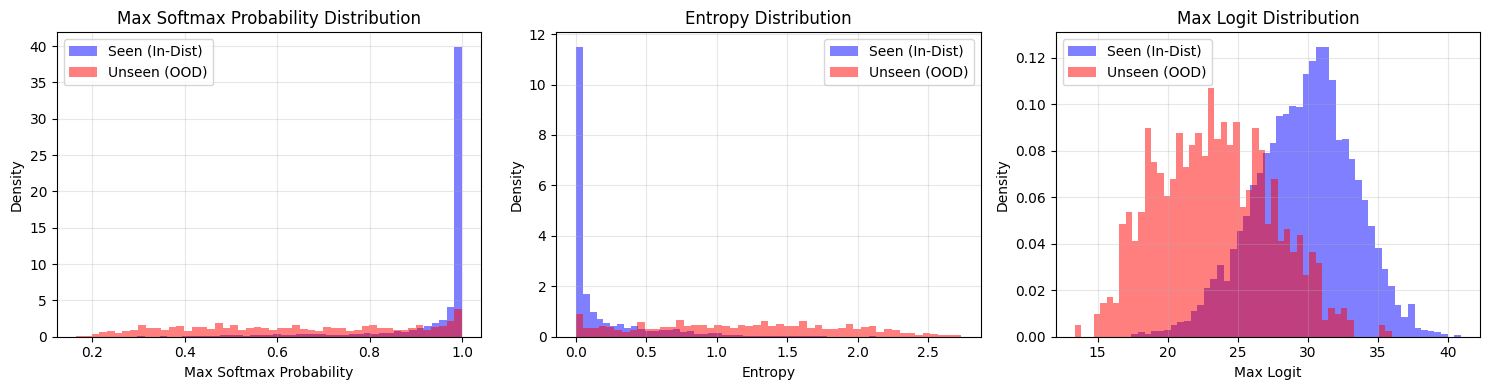


Training on Real World...


Epoch 1/10: 100%|██████████| 69/69 [02:11<00:00,  1.90s/it]


Epoch 1/10 finished, Accuracy: 0.8240


Epoch 2/10: 100%|██████████| 69/69 [02:12<00:00,  1.92s/it]


Epoch 2/10 finished, Accuracy: 0.8986


Epoch 3/10: 100%|██████████| 69/69 [02:12<00:00,  1.92s/it]


Epoch 3/10 finished, Accuracy: 0.9135


Epoch 4/10:  38%|███▊      | 26/69 [00:52<01:26,  2.02s/it]


KeyboardInterrupt: 

In [14]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm import tqdm
import matplotlib.pyplot as plt

def split_seen_unseen_classes(all_classes, seen_ratio=0.8, seed=42):
    """Split classes into seen and unseen sets"""
    np.random.seed(seed)
    n_classes = len(all_classes)
    n_seen = int(n_classes * seen_ratio)
    
    indices = np.random.permutation(n_classes)
    seen_indices = sorted(indices[:n_seen])
    unseen_indices = sorted(indices[n_seen:])
    
    seen_classes = [all_classes[i] for i in seen_indices]
    unseen_classes = [all_classes[i] for i in unseen_indices]
    
    return seen_classes, unseen_classes, seen_indices, unseen_indices

def create_seen_unseen_datasets(original_dataset, seen_indices, unseen_indices):
    """Split dataset into seen and unseen class samples"""
    seen_samples = []
    unseen_samples = []
    
    for img, label in original_dataset:
        if label in seen_indices:
            # Remap label to new index in seen classes
            new_label = seen_indices.index(label)
            seen_samples.append((img, new_label))
        elif label in unseen_indices:
            # Keep original label for unseen (for tracking)
            unseen_samples.append((img, label))
    
    return seen_samples, unseen_samples

class SeenUnseenDataset(torch.utils.data.Dataset):
    """Dataset wrapper for seen/unseen splits"""
    def __init__(self, samples):
        self.samples = samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

def compute_confidence_metrics(logits, labels=None):
    """
    Compute various confidence metrics for open-set detection
    
    Returns:
    - max_softmax_prob (MSP): Maximum softmax probability
    - entropy: Prediction entropy
    - max_logit: Maximum logit value
    """
    probs = F.softmax(logits, dim=1)
    
    # Maximum Softmax Probability (MSP)
    msp, predictions = probs.max(dim=1)
    
    # Entropy
    entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1)
    
    # Maximum logit
    max_logit, _ = logits.max(dim=1)
    
    metrics = {
        'msp': msp.cpu().numpy(),
        'entropy': entropy.cpu().numpy(),
        'max_logit': max_logit.cpu().numpy(),
        'predictions': predictions.cpu().numpy()
    }
    
    if labels is not None:
        accuracy = (predictions == labels).float().mean().item()
        metrics['accuracy'] = accuracy
    
    return metrics

def evaluate_open_set(model, seen_loader, unseen_loader, device="cuda"):
    """
    Evaluate open-set performance
    
    Returns metrics comparing seen (in-distribution) vs unseen (out-of-distribution)
    """
    model.eval()
    
    seen_metrics = {'msp': [], 'entropy': [], 'max_logit': []}
    unseen_metrics = {'msp': [], 'entropy': [], 'max_logit': []}
    
    print("Evaluating on SEEN classes (in-distribution)...")
    seen_correct = 0
    seen_total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(seen_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            metrics = compute_confidence_metrics(logits, labels)
            
            seen_metrics['msp'].extend(metrics['msp'])
            seen_metrics['entropy'].extend(metrics['entropy'])
            seen_metrics['max_logit'].extend(metrics['max_logit'])
            
            seen_correct += (metrics['predictions'] == labels.cpu().numpy()).sum()
            seen_total += len(labels)
    
    print(f"Seen class accuracy: {seen_correct/seen_total:.4f}")
    
    print("\nEvaluating on UNSEEN classes (out-of-distribution)...")
    with torch.no_grad():
        for images, labels in tqdm(unseen_loader):
            images = images.to(device)
            
            logits = model(images)
            metrics = compute_confidence_metrics(logits)
            
            unseen_metrics['msp'].extend(metrics['msp'])
            unseen_metrics['entropy'].extend(metrics['entropy'])
            unseen_metrics['max_logit'].extend(metrics['max_logit'])
    
    # Convert to numpy arrays
    for key in seen_metrics:
        seen_metrics[key] = np.array(seen_metrics[key])
        unseen_metrics[key] = np.array(unseen_metrics[key])
    
    # Compute AUROC for open-set detection
    # Label: 1 for in-distribution (seen), 0 for out-of-distribution (unseen)
    true_labels = np.concatenate([
        np.ones(len(seen_metrics['msp'])),
        np.zeros(len(unseen_metrics['msp']))
    ])
    
    results = {}
    
    for metric_name in ['msp', 'entropy', 'max_logit']:
        seen_scores = seen_metrics[metric_name]
        unseen_scores = unseen_metrics[metric_name]
        
        # For MSP and max_logit: higher = more confident (in-dist)
        # For entropy: lower = more confident (in-dist), so negate it
        if metric_name == 'entropy':
            all_scores = np.concatenate([-seen_scores, -unseen_scores])
        else:
            all_scores = np.concatenate([seen_scores, unseen_scores])
        
        auroc = roc_auc_score(true_labels, all_scores)
        
        # Compute FPR@95 (FPR when TPR=95%)
        fpr, tpr, thresholds = roc_curve(true_labels, all_scores)
        fpr_at_95 = fpr[np.argmax(tpr >= 0.95)]
        
        results[metric_name] = {
            'auroc': auroc,
            'fpr_at_95': fpr_at_95,
            'seen_mean': seen_scores.mean(),
            'seen_std': seen_scores.std(),
            'unseen_mean': unseen_scores.mean(),
            'unseen_std': unseen_scores.std()
        }
    
    return results, seen_metrics, unseen_metrics, seen_correct/seen_total

def print_open_set_results(results, model_name="Model"):
    """Print formatted open-set evaluation results"""
    print("\n" + "="*70)
    print(f"OPEN-SET EVALUATION: {model_name}")
    print("="*70)
    
    for metric_name, metrics in results.items():
        print(f"\n{metric_name.upper()} Metric:")
        print(f"  AUROC:                {metrics['auroc']:.4f}")
        print(f"  FPR@95% TPR:          {metrics['fpr_at_95']:.4f}")
        print(f"  Seen (mean ± std):    {metrics['seen_mean']:.4f} ± {metrics['seen_std']:.4f}")
        print(f"  Unseen (mean ± std):  {metrics['unseen_mean']:.4f} ± {metrics['unseen_std']:.4f}")
        print(f"  Separation:           {abs(metrics['seen_mean'] - metrics['unseen_mean']):.4f}")

def visualize_confidence_distributions(seen_metrics, unseen_metrics, save_path=None):
    """Visualize confidence score distributions for seen vs unseen"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    metrics_to_plot = [('msp', 'Max Softmax Probability'), 
                       ('entropy', 'Entropy'),
                       ('max_logit', 'Max Logit')]
    
    for idx, (metric_name, title) in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        ax.hist(seen_metrics[metric_name], bins=50, alpha=0.5, 
                label='Seen (In-Dist)', density=True, color='blue')
        ax.hist(unseen_metrics[metric_name], bins=50, alpha=0.5, 
                label='Unseen (OOD)', density=True, color='red')
        
        ax.set_xlabel(title)
        ax.set_ylabel('Density')
        ax.set_title(f'{title} Distribution')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def compute_prompt_similarity(model1, model2):
    """
    Compute cosine similarity between prompt embeddings of two models
    """
    # Get context vectors (learnable prompts)
    ctx1 = model1.prompt_learner.ctx.data  # [n_ctx, ctx_dim]
    ctx2 = model2.prompt_learner.ctx.data  # [n_ctx, ctx_dim]
    
    # Flatten
    ctx1_flat = ctx1.flatten()
    ctx2_flat = ctx2.flatten()
    
    # Cosine similarity
    cos_sim = F.cosine_similarity(ctx1_flat.unsqueeze(0), 
                                   ctx2_flat.unsqueeze(0)).item()
    
    # L2 distance
    l2_dist = torch.norm(ctx1_flat - ctx2_flat).item()
    
    return {
        'cosine_similarity': cos_sim,
        'l2_distance': l2_dist
    }

def analyze_prompt_embeddings(models_dict):
    """
    Analyze similarities between prompts learned for different domains
    
    models_dict: {'domain_name': model}
    """
    print("\n" + "="*70)
    print("PROMPT EMBEDDING SIMILARITY ANALYSIS")
    print("="*70)
    
    domain_names = list(models_dict.keys())
    n_domains = len(domain_names)
    
    # Compute pairwise similarities
    similarity_matrix = np.zeros((n_domains, n_domains))
    
    for i, domain1 in enumerate(domain_names):
        for j, domain2 in enumerate(domain_names):
            if i == j:
                similarity_matrix[i, j] = 1.0
            else:
                sim = compute_prompt_similarity(
                    models_dict[domain1], 
                    models_dict[domain2]
                )
                similarity_matrix[i, j] = sim['cosine_similarity']
    
    # Print results
    print("\nCosine Similarity Matrix:")
    print("\n" + " "*15 + "".join([f"{name:>12}" for name in domain_names]))
    for i, domain1 in enumerate(domain_names):
        row_str = f"{domain1:>12}  "
        row_str += "".join([f"{similarity_matrix[i, j]:>12.4f}" for j in range(n_domains)])
        print(row_str)
    
    # Compute average cross-domain similarity
    mask = ~np.eye(n_domains, dtype=bool)
    avg_cross_sim = similarity_matrix[mask].mean()
    
    print(f"\nAverage cross-domain similarity: {avg_cross_sim:.4f}")
    
    if avg_cross_sim < 0.3:
        print("⚠️  Low similarity suggests domain-specific prompt learning")
    elif avg_cross_sim > 0.8:
        print("✓  High similarity suggests domain-invariant prompts")
    else:
        print("→  Moderate similarity suggests partial domain adaptation")
    
    return similarity_matrix

def full_open_set_experiment(source_dataset, target_dataset, office_home_classes, 
                             seen_ratio=0.8, device="cuda"):
    """
    Complete open-set experiment pipeline
    """
    print("="*70)
    print("OPEN-SET EXPERIMENT: Training on subset, testing on all")
    print("="*70)
    
    # 1. Split classes
    seen_classes, unseen_classes, seen_indices, unseen_indices = \
        split_seen_unseen_classes(office_home_classes, seen_ratio=seen_ratio)
    
    print(f"\nSeen classes ({len(seen_classes)}): {seen_classes}...")
    print(f"Unseen classes ({len(unseen_classes)}): {unseen_classes}")
    
    # 2. Create datasets
    seen_samples, unseen_samples = create_seen_unseen_datasets(
        source_dataset, seen_indices, unseen_indices
    )
    
    seen_dataset = SeenUnseenDataset(seen_samples)
    unseen_dataset = SeenUnseenDataset(unseen_samples)
    
    seen_loader = torch.utils.data.DataLoader(
        seen_dataset, batch_size=64, shuffle=True
    )
    unseen_loader = torch.utils.data.DataLoader(
        unseen_dataset, batch_size=64, shuffle=False
    )
    
    print(f"\nSeen samples: {len(seen_samples)}")
    print(f"Unseen samples: {len(unseen_samples)}")
    
    # # 3. Train zero-shot CLIP (baseline)
    # print("\n" + "-"*70)
    # print("BASELINE: Zero-shot CLIP")
    # print("-"*70)
    
    clip_model, _ = clip.load("ViT-B/16", device=device)
    clip_model.float()
    
    # zero_shot_model = CLIPWithPrompt(
    #     clip_model, office_home_classes, n_ctx=0, device=device
    # )  # n_ctx=0 means no learnable context

    
    
    # For zero-shot, we need to modify the model slightly
    # Actually, let's just use the original CLIP
    
    # 4. Train tuned prompt on SEEN classes only
    print("\n" + "-"*70)
    print("TRAINING: Prompt tuning on SEEN classes only")
    print("-"*70)
    
    clip_model_tuned, _ = clip.load("ViT-B/16", device=device)
    clip_model_tuned.float()
    
    tuned_model = CLIPWithPrompt(
        clip_model_tuned, seen_classes, n_ctx=16, device=device
    )
    
    # Train on seen classes
    tuned_model = train_coop_source_only(
        tuned_model,
        train_loader=seen_loader,
        num_epochs=15,
        lr=0.002,
        device=device
    )
    
    # 5. Evaluate both models
    print("\n" + "-"*70)
    print("EVALUATION: Open-set performance")
    print("-"*70)
    
    # For fair comparison, we need to evaluate zero-shot on all classes
    # but tuned model only knows seen classes
    
    # Create test loaders for seen classes from target domain
    target_seen_samples, target_unseen_samples = create_seen_unseen_datasets(
        target_dataset, seen_indices, unseen_indices
    )
    
    target_seen_dataset = SeenUnseenDataset(target_seen_samples)
    target_unseen_dataset = SeenUnseenDataset(target_unseen_samples)
    
    target_seen_loader = torch.utils.data.DataLoader(
        target_seen_dataset, batch_size=64, shuffle=True
    )
    target_unseen_loader = torch.utils.data.DataLoader(
        target_unseen_dataset, batch_size=64, shuffle=True
    )

        # Evaluate tuned model
    tuned_results, tuned_seen, tuned_unseen, tuned_acc = evaluate_open_set(
        clip_model, target_seen_loader, target_unseen_loader, device
    )
    
    print_open_set_results(tuned_results, "Prompt-Tuned Model")
    
    # # Evaluate tuned model
    # tuned_results, tuned_seen, tuned_unseen, tuned_acc = evaluate_open_set(
    #     tuned_model, target_seen_loader, target_unseen_loader, device
    # )
    
    # print_open_set_results(tuned_results, "Prompt-Tuned Model")
    
    # 6. Visualize
    visualize_confidence_distributions(
        tuned_seen, tuned_unseen, 
        save_path='open_set_confidence_distributions.png'
    )
    
    return {
        'tuned': tuned_results,
        'tuned_model': tuned_model,
        'seen_classes': seen_classes,
        'unseen_classes': unseen_classes
    }


# Run open-set experiment
open_set_results = full_open_set_experiment(
    source_dataset=datasets_dict["Real World"],
    target_dataset=datasets_dict["Real World"],
    office_home_classes=office_home_classes,
    seen_ratio=0.8,
    device=device
)

# Train models on different domains and compare prompts
models_by_domain = {}

for domain_name in ["Real World", "Art", "Clipart"]:
    print(f"\nTraining on {domain_name}...")
    
    clip_model, _ = clip.load("ViT-B/16", device=device)
    clip_model.float()
    
    model = CLIPWithPrompt(clip_model, office_home_classes, n_ctx=16, device=device)
    
    domain_loader = DataLoader(
        datasets_dict[domain_name], 
        batch_size=64, 
        shuffle=True
    )
    
    model = train_coop_source_only(
        model, domain_loader, num_epochs=10, device=device
    )
    
    models_by_domain[domain_name] = model

# Analyze prompt similarities across domains
similarity_matrix = analyze_prompt_embeddings(models_by_domain)


OPEN-SET EXPERIMENT: Training on subset, testing on all

Seen classes (52): ['Alarm_Clock', 'Backpack', 'Batteries', 'Bed', 'Bike', 'Bottle', 'Bucket', 'Calendar', 'Candles', 'Clipboards', 'Computer', 'Couch', 'Desk_Lamp', 'Drill', 'Eraser', 'Fan', 'Flipflops', 'Fork', 'Glasses', 'Hammer', 'Helmet', 'Keyboard', 'Knives', 'Lamp_Shade', 'Laptop', 'Marker', 'Monitor', 'Mop', 'Mouse', 'Mug', 'Oven', 'Pan', 'Paper_Clip', 'Pencil', 'Postit_Notes', 'Printer', 'Push_Pin', 'Radio', 'Refrigerator', 'Ruler', 'Scissors', 'Shelf', 'Sink', 'Soda', 'Speaker', 'Table', 'Telephone', 'ToothBrush', 'Toys', 'Trash_Can', 'TV', 'Webcam']
Unseen classes (13): ['Calculator', 'Chair', 'Curtains', 'Exit_Sign', 'File_Cabinet', 'Flowers', 'Folder', 'Kettle', 'Notebook', 'Pen', 'Screwdriver', 'Sneakers', 'Spoon']

Training samples (seen classes only): 3446

----------------------------------------------------------------------
TRAINING: Prompt tuning on SEEN classes only
-------------------------------------------

100%|██████████| 54/54 [00:22<00:00,  2.44it/s]


Zero-shot seen class accuracy: 0.7803

Evaluating zero-shot on UNSEEN classes (out-of-distribution)...


100%|██████████| 15/15 [00:05<00:00,  2.58it/s]



OPEN-SET EVALUATION: Zero-Shot CLIP

MSP Metric:
  AUROC:                0.9051
  FPR@95% TPR:          0.4720
  Seen (mean ± std):    0.8748 ± 0.1828
  Unseen (mean ± std):  0.4718 ± 0.2343
  Separation:           0.4031

ENTROPY Metric:
  AUROC:                0.9186
  FPR@95% TPR:          0.4094
  Seen (mean ± std):    0.4591 ± 0.5748
  Unseen (mean ± std):  1.8819 ± 0.8011
  Separation:           1.4228

MAX_LOGIT Metric:
  AUROC:                0.8696
  FPR@95% TPR:          0.5214
  Seen (mean ± std):    29.9989 ± 2.5741
  Unseen (mean ± std):  25.7323 ± 2.8039
  Separation:           4.2666

----------------------------------------------------------------------
EVALUATION: Prompt-Tuned Model
----------------------------------------------------------------------
Evaluating on SEEN classes (in-distribution)...


100%|██████████| 54/54 [00:25<00:00,  2.14it/s]


Seen class accuracy: 0.5444

Evaluating on UNSEEN classes (out-of-distribution)...


100%|██████████| 15/15 [00:06<00:00,  2.23it/s]



OPEN-SET EVALUATION: Prompt-Tuned Model

MSP Metric:
  AUROC:                0.7312
  FPR@95% TPR:          0.8990
  Seen (mean ± std):    0.3460 ± 0.2604
  Unseen (mean ± std):  0.1685 ± 0.1213
  Separation:           0.1776

ENTROPY Metric:
  AUROC:                0.7486
  FPR@95% TPR:          0.8507
  Seen (mean ± std):    2.8015 ± 0.9598
  Unseen (mean ± std):  3.4351 ± 0.3835
  Separation:           0.6336

MAX_LOGIT Metric:
  AUROC:                0.6405
  FPR@95% TPR:          0.9473
  Seen (mean ± std):    24.2516 ± 2.1444
  Unseen (mean ± std):  23.2776 ± 1.6075
  Separation:           0.9740

COMPARISON: Zero-Shot vs Prompt-Tuned

Seen Class Accuracy:
  Zero-Shot:     0.7803
  Prompt-Tuned:  0.5444
  Improvement:   -0.2359 (-23.59%)

Open-Set Detection (AUROC - higher is better):
  MSP:
    Zero-Shot:     0.9051
    Prompt-Tuned:  0.7312
    Difference:    -0.1739
  ENTROPY:
    Zero-Shot:     0.9186
    Prompt-Tuned:  0.7486
    Difference:    -0.1701
  MAX_LOGIT:
    Zero

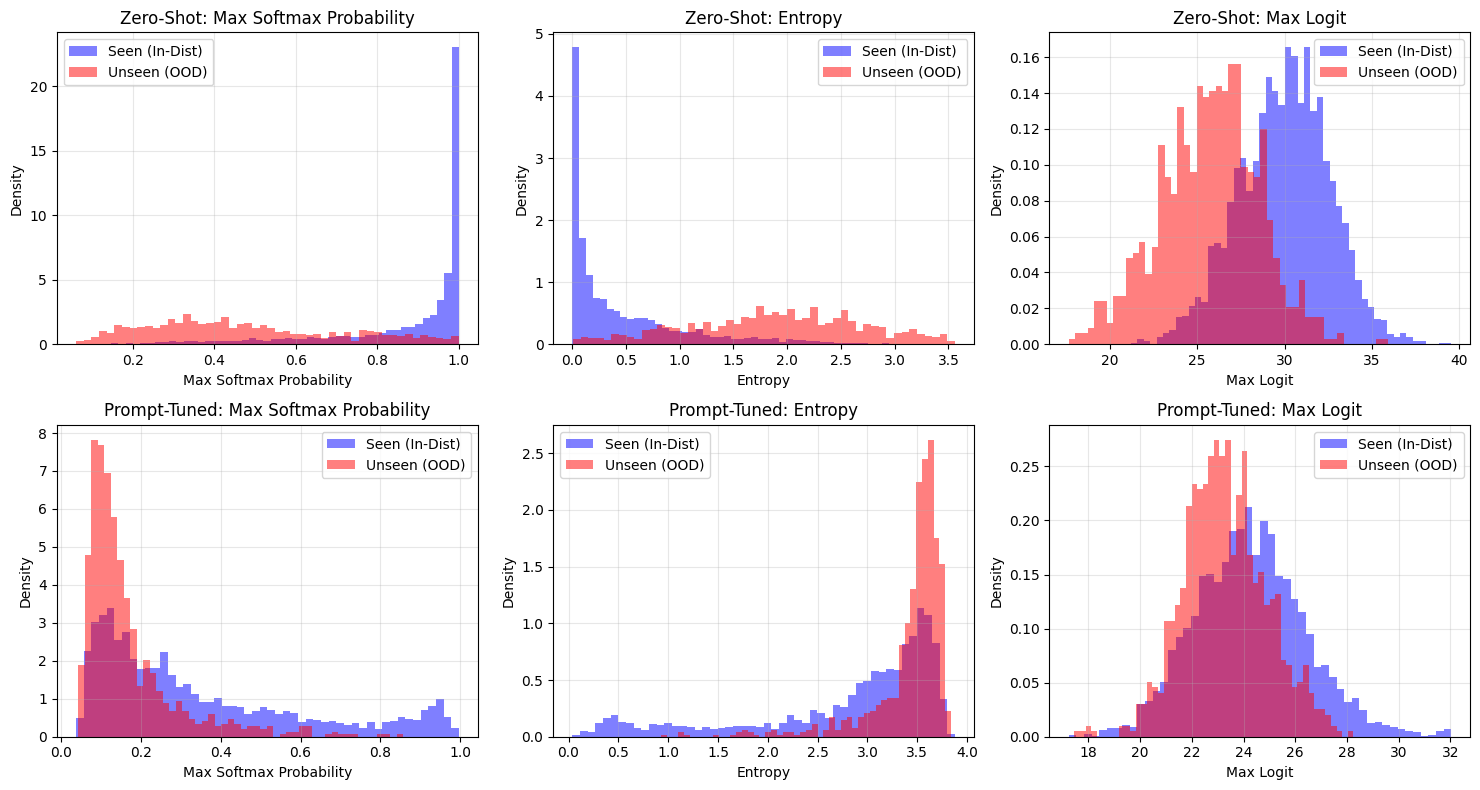

In [16]:
def evaluate_zero_shot_with_metrics(model, seen_loader, unseen_loader, 
                                    seen_classes, device="cuda"):
    """
    Evaluate zero-shot CLIP and compute open-set metrics
    Uses raw CLIP model with standard text prompts
    """
    model.eval()
    
    # Prepare text embeddings for SEEN classes only
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") 
                            for c in seen_classes]).to(device)
    
    with torch.no_grad():
        text_features = model.encode_text(text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    seen_metrics = {'msp': [], 'entropy': [], 'max_logit': []}
    unseen_metrics = {'msp': [], 'entropy': [], 'max_logit': []}
    
    seen_correct = 0
    seen_total = 0
    
    print("Evaluating zero-shot on SEEN classes (in-distribution)...")
    with torch.no_grad():
        for images, labels in tqdm(seen_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            # Encode images
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            # Compute logits
            logits = 100. * image_features @ text_features.T
            
            # Compute metrics
            metrics = compute_confidence_metrics(logits, labels)
            
            seen_metrics['msp'].extend(metrics['msp'])
            seen_metrics['entropy'].extend(metrics['entropy'])
            seen_metrics['max_logit'].extend(metrics['max_logit'])
            
            seen_correct += (metrics['predictions'] == labels.cpu().numpy()).sum()
            seen_total += len(labels)
    
    print(f"Zero-shot seen class accuracy: {seen_correct/seen_total:.4f}")
    
    print("\nEvaluating zero-shot on UNSEEN classes (out-of-distribution)...")
    with torch.no_grad():
        for images, labels in tqdm(unseen_loader):
            images = images.to(device)
            
            # Encode images
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            # Compute logits (unseen images against SEEN class prompts)
            logits = 100. * image_features @ text_features.T
            
            # Compute metrics
            metrics = compute_confidence_metrics(logits)
            
            unseen_metrics['msp'].extend(metrics['msp'])
            unseen_metrics['entropy'].extend(metrics['entropy'])
            unseen_metrics['max_logit'].extend(metrics['max_logit'])
    
    # Convert to numpy
    for key in seen_metrics:
        seen_metrics[key] = np.array(seen_metrics[key])
        unseen_metrics[key] = np.array(unseen_metrics[key])
    
    # Compute AUROC
    true_labels = np.concatenate([
        np.ones(len(seen_metrics['msp'])),
        np.zeros(len(unseen_metrics['msp']))
    ])
    
    results = {}
    
    for metric_name in ['msp', 'entropy', 'max_logit']:
        seen_scores = seen_metrics[metric_name]
        unseen_scores = unseen_metrics[metric_name]
        
        if metric_name == 'entropy':
            all_scores = np.concatenate([-seen_scores, -unseen_scores])
        else:
            all_scores = np.concatenate([seen_scores, unseen_scores])
        
        auroc = roc_auc_score(true_labels, all_scores)
        fpr, tpr, thresholds = roc_curve(true_labels, all_scores)
        fpr_at_95 = fpr[np.argmax(tpr >= 0.95)]
        
        results[metric_name] = {
            'auroc': auroc,
            'fpr_at_95': fpr_at_95,
            'seen_mean': seen_scores.mean(),
            'seen_std': seen_scores.std(),
            'unseen_mean': unseen_scores.mean(),
            'unseen_std': unseen_scores.std()
        }
    
    return results, seen_metrics, unseen_metrics, seen_correct/seen_total


def full_open_set_experiment(source_dataset, target_dataset, office_home_classes, 
                             seen_ratio=0.8, device="cuda"):
    """
    Complete open-set experiment pipeline
    """
    print("="*70)
    print("OPEN-SET EXPERIMENT: Training on subset, testing on all")
    print("="*70)
    
    # 1. Split classes
    seen_classes, unseen_classes, seen_indices, unseen_indices = \
        split_seen_unseen_classes(office_home_classes, seen_ratio=seen_ratio)
    
    print(f"\nSeen classes ({len(seen_classes)}): {seen_classes}")
    print(f"Unseen classes ({len(unseen_classes)}): {unseen_classes}")
    
    # 2. Create TRAINING datasets (from source domain)
    seen_samples, unseen_samples = create_seen_unseen_datasets(
        source_dataset, seen_indices, unseen_indices
    )
    
    seen_dataset = SeenUnseenDataset(seen_samples)
    
    seen_loader = torch.utils.data.DataLoader(
        seen_dataset, batch_size=64, shuffle=True
    )
    
    print(f"\nTraining samples (seen classes only): {len(seen_samples)}")
    
    # 3. Train tuned prompt on SEEN classes only
    print("\n" + "-"*70)
    print("TRAINING: Prompt tuning on SEEN classes only")
    print("-"*70)
    
    clip_model_tuned, _ = clip.load("ViT-B/16", device=device)
    clip_model_tuned.float()
    
    tuned_model = CLIPWithPrompt(
        clip_model_tuned, seen_classes, n_ctx=16, device=device
    )
    
    # Train on seen classes
    # tuned_model = train_coop_source_only(
    #     tuned_model,
    #     train_loader=seen_loader,
    #     num_epochs=15,
    #     lr=0.002,
    #     device=device
    # )
    
    # 4. Create TEST datasets (from target domain)
    print("\n" + "-"*70)
    print("EVALUATION: Creating test datasets")
    print("-"*70)
    
    target_seen_samples, target_unseen_samples = create_seen_unseen_datasets(
        target_dataset, seen_indices, unseen_indices
    )
    
    target_seen_dataset = SeenUnseenDataset(target_seen_samples)
    target_unseen_dataset = SeenUnseenDataset(target_unseen_samples)
    
    target_seen_loader = torch.utils.data.DataLoader(
        target_seen_dataset, batch_size=64, shuffle=False
    )
    target_unseen_loader = torch.utils.data.DataLoader(
        target_unseen_dataset, batch_size=64, shuffle=False
    )
    
    print(f"Test samples - Seen classes: {len(target_seen_samples)}")
    print(f"Test samples - Unseen classes: {len(target_unseen_samples)}")
    
    # 5. Evaluate ZERO-SHOT CLIP (baseline)
    print("\n" + "-"*70)
    print("BASELINE: Zero-shot CLIP")
    print("-"*70)
    
    clip_model_zeroshot, _ = clip.load("ViT-B/16", device=device)
    clip_model_zeroshot.float()
    
    zeroshot_results, zeroshot_seen, zeroshot_unseen, zeroshot_acc = \
        evaluate_zero_shot_with_metrics(
            clip_model_zeroshot,
            target_seen_loader,
            target_unseen_loader,
            seen_classes,
            device
        )
    
    print_open_set_results(zeroshot_results, "Zero-Shot CLIP")
    
    # 6. Evaluate PROMPT-TUNED model
    print("\n" + "-"*70)
    print("EVALUATION: Prompt-Tuned Model")
    print("-"*70)
    
    tuned_results, tuned_seen, tuned_unseen, tuned_acc = evaluate_open_set(
        tuned_model, target_seen_loader, target_unseen_loader, device
    )
    
    print_open_set_results(tuned_results, "Prompt-Tuned Model")
    
    # 7. Compare the two models
    print("\n" + "="*70)
    print("COMPARISON: Zero-Shot vs Prompt-Tuned")
    print("="*70)
    
    print(f"\nSeen Class Accuracy:")
    print(f"  Zero-Shot:     {zeroshot_acc:.4f}")
    print(f"  Prompt-Tuned:  {tuned_acc:.4f}")
    print(f"  Improvement:   {tuned_acc - zeroshot_acc:+.4f} ({(tuned_acc - zeroshot_acc)*100:+.2f}%)")
    
    print(f"\nOpen-Set Detection (AUROC - higher is better):")
    for metric in ['msp', 'entropy', 'max_logit']:
        zs_auroc = zeroshot_results[metric]['auroc']
        pt_auroc = tuned_results[metric]['auroc']
        print(f"  {metric.upper()}:")
        print(f"    Zero-Shot:     {zs_auroc:.4f}")
        print(f"    Prompt-Tuned:  {pt_auroc:.4f}")
        print(f"    Difference:    {pt_auroc - zs_auroc:+.4f}")
    
    print(f"\nFalse Positive Rate @ 95% TPR (lower is better):")
    for metric in ['msp', 'entropy', 'max_logit']:
        zs_fpr = zeroshot_results[metric]['fpr_at_95']
        pt_fpr = tuned_results[metric]['fpr_at_95']
        print(f"  {metric.upper()}:")
        print(f"    Zero-Shot:     {zs_fpr:.4f}")
        print(f"    Prompt-Tuned:  {pt_fpr:.4f}")
        print(f"    Difference:    {pt_fpr - zs_fpr:+.4f}")
    
    print(f"\nConfidence on Unseen Classes (MSP - lower is better for OOD):")
    zs_unseen_msp = zeroshot_results['msp']['unseen_mean']
    pt_unseen_msp = tuned_results['msp']['unseen_mean']
    print(f"  Zero-Shot:     {zs_unseen_msp:.4f}")
    print(f"  Prompt-Tuned:  {pt_unseen_msp:.4f}")
    print(f"  Difference:    {pt_unseen_msp - zs_unseen_msp:+.4f}")
    
    # 8. Visualize both models
    print("\n" + "-"*70)
    print("Creating visualizations...")
    print("-"*70)
    
    # Create side-by-side comparison
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    metrics_to_plot = [('msp', 'Max Softmax Probability'), 
                       ('entropy', 'Entropy'),
                       ('max_logit', 'Max Logit')]
    
    # Plot zero-shot (top row)
    for idx, (metric_name, title) in enumerate(metrics_to_plot):
        ax = axes[0, idx]
        ax.hist(zeroshot_seen[metric_name], bins=50, alpha=0.5, 
                label='Seen (In-Dist)', density=True, color='blue')
        ax.hist(zeroshot_unseen[metric_name], bins=50, alpha=0.5, 
                label='Unseen (OOD)', density=True, color='red')
        ax.set_xlabel(title)
        ax.set_ylabel('Density')
        ax.set_title(f'Zero-Shot: {title}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot prompt-tuned (bottom row)
    for idx, (metric_name, title) in enumerate(metrics_to_plot):
        ax = axes[1, idx]
        ax.hist(tuned_seen[metric_name], bins=50, alpha=0.5, 
                label='Seen (In-Dist)', density=True, color='blue')
        ax.hist(tuned_unseen[metric_name], bins=50, alpha=0.5, 
                label='Unseen (OOD)', density=True, color='red')
        ax.set_xlabel(title)
        ax.set_ylabel('Density')
        ax.set_title(f'Prompt-Tuned: {title}')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('open_set_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'zeroshot': zeroshot_results,
        'tuned': tuned_results,
        'tuned_model': tuned_model,
        'seen_classes': seen_classes,
        'unseen_classes': unseen_classes,
        'zeroshot_acc': zeroshot_acc,
        'tuned_acc': tuned_acc
    }


# Run the complete experiment
open_set_results = full_open_set_experiment(
    source_dataset=datasets_dict["Real World"],
    target_dataset=datasets_dict["Real World"],
    office_home_classes=office_home_classes,
    seen_ratio=0.8,
    device=device
)